In [1]:
from MonteCarlo import MonteCarlo
import numpy as np


In [16]:
sample = np.random.randn(10**3)

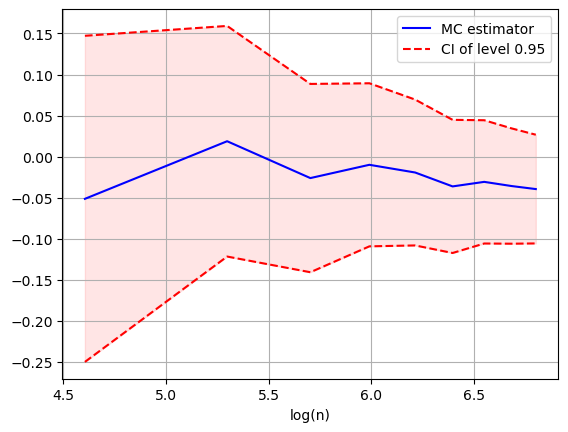

In [18]:
mc = MonteCarlo(sample=sample, confidence_level=0.95)
mc.convergence_diagram(plot_intervals=True, log=True)

In [3]:
import numpy as np
from BlackScholes import BlackScholes

In [4]:
r = 0.05
sigma = 0.2

S0 = 100
K = 100
T = 2

model = BlackScholes(sigma, r)

In [5]:
n_sample = 10**7
rng = np.random.default_rng(seed=42)
trajs = model.simulate_trajectory(n_sample=n_sample, t_grid=[T], init_val=S0, random_state=rng)

In [9]:
np.array(True, dtype='float')

array(1.)

In [12]:
def payoff_call(x, K=K):
    return np.maximum(x - K, 0)

def grad_payoff_call(x, K=K):
    return np.array(x - K >= 0, dtype='float')

In [15]:
np.mean(np.exp(-r * T) * grad_payoff_call(trajs) * trajs / S0)

0.6897171924549855

In [ ]:
np.mean(np.exp(-r * T) * payoff_call(trajs) * trajs / S0)